# 1. 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

데이터프레임의 넘파이 데이터를 파이토치 데이터로 변환하고 크기를 확인

In [4]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 30]) torch.Size([569, 1])


학습/검증/테스트 데이터셋으로 나누기

In [7]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print('Train %d / Valid %d / Test %d samples.' % (train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


개수대로 랜덤하게 섞기

In [8]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


학습 데이터를 기준으로 표준 스케일링 적용

In [9]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(),
     torch.from_numpy(scaler.transform(x[2].numpy())).float()]

# 2. 학습 코드 구현

In [10]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25,20),
    nn.LeakyReLU(),
    nn.Linear(20,15),
    nn.LeakyReLU(),
    nn.Linear(15,10),
    nn.LeakyReLU(),
    nn.Linear(10,5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid(),
)

optimizer = optim.Adam(model.parameters())

학습에 필요한 하이퍼파라미터를 설정

In [12]:
n_epochs = 10000
batch_size = 32
print_interval = 10
early_stop = 100
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

모델 학습 이터레이션을 진행
- 손실함수를 BCE 함수를 사용 : F.binary_cross_entropy

In [13]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)
        
    train_loss = train_loss / len(x_)
    
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e valid_loss=%.4e lowest_loss=%.4e' % 
              (i+1, train_loss, valid_loss, lowest_loss))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
        
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print('There is no improvement during last %d epochs.' % early_stop)
            break
            
print('The best validation loss from epoch %d: %.4e' % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=3.5458e-01 valid_loss=3.0042e-01 lowest_loss=3.9547e-01
Epoch 20: train loss=6.4047e-02 valid_loss=4.0738e-02 lowest_loss=4.6600e-02
Epoch 30: train loss=4.9899e-02 valid_loss=3.5826e-02 lowest_loss=3.6995e-02
Epoch 40: train loss=4.6595e-02 valid_loss=2.6946e-02 lowest_loss=2.9728e-02
Epoch 50: train loss=3.8743e-02 valid_loss=1.8002e-02 lowest_loss=1.8858e-02
Epoch 60: train loss=2.8314e-02 valid_loss=1.6172e-02 lowest_loss=1.5692e-02
Epoch 70: train loss=1.4460e-02 valid_loss=3.5138e-02 lowest_loss=1.5692e-02
Epoch 80: train loss=4.4392e-03 valid_loss=6.0043e-02 lowest_loss=1.5692e-02
Epoch 90: train loss=1.5988e-03 valid_loss=5.7685e-02 lowest_loss=1.5692e-02
Epoch 100: train loss=8.3668e-04 valid_loss=6.3297e-02 lowest_loss=1.5692e-02
Epoch 110: train loss=5.0230e-04 valid_loss=6.0855e-02 lowest_loss=1.5692e-02
Epoch 120: train loss=3.4258e-04 valid_loss=6.2719e-02 lowest_loss=1.5692e-02
Epoch 130: train loss=2.4647e-04 valid_loss=6.5540e-02 lowest_loss=1.5692

<All keys matched successfully>

# 3. 손실 곡선 확인

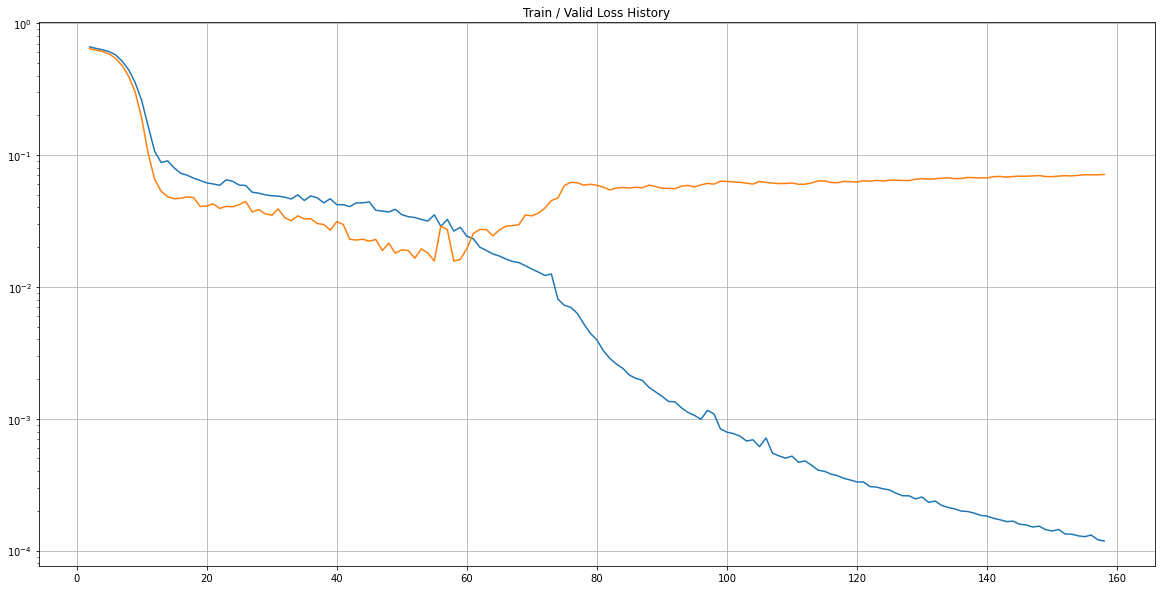

In [14]:
plot_from = 2

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Train / Valid Loss History')
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

# 4. 결과 확인

In [17]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        test_loss += loss # Gradient is already detached
        
        y_hat += [y_hat_i]
        
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history),
                       key = lambda x:x[1])

print('Train loss: %.4e' % sorted_history[0][0])
print('Valid loss: %.4e' % sorted_history[0][1])
print('Test loss: %.re' % test_loss)

Train loss: 2.6505e-02
Valid loss: 1.5692e-02
Test loss: e


일반적인 회귀가 아닌 분류이기 때문에 정확도도 계산 가능
- 모델의 예측값이 0.5보다 클 경우에 1로 예측한 것으로 가정
- 0.5보다 작거나 같은 경우에는 0으로 예측한 것이라 가정

In [16]:
correct_cnt = (y[2] == (y_hat >.5)).sum()
total_cnt = float(y[2].size(0))

print('Test Accuracy: %.4f' % (correct_cnt/total_cnt))

Test Accuracy: 0.9826


예측값의 분포 확인

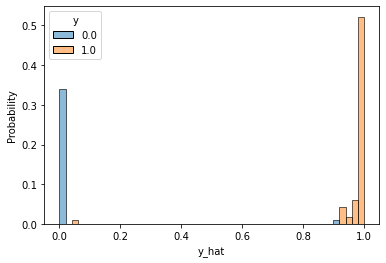

In [18]:
df = pd.DataFrame(torch.cat([y[2],y_hat], dim=1).detach().numpy(), columns=['y', 'y_hat'])

sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df.values[:, 0], df.values[:, -1])

0.9996666666666667